<a href="https://colab.research.google.com/github/pharringtonp19/mecon/blob/main/notebooks/Profit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
#@title Installs { display-mode: "form" }
%%capture 
!pip install jaxopt 

In [24]:
#@title Imports { display-mode: "form" }
import jax 
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp 
import jaxopt
from functools import partial 

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [27]:
#@title Inverse Demand Higher Order Function { display-mode: "form" }
def inverse(f):

  def inverse_fn(q):
    
    def closure(p, q):
      return (f(p)-q)**2

    solver = jaxopt.GradientDescent(fun=closure, maxiter=2000)
    res = solver.run(jnp.ones(shape=()), q)
    return res.params

  return inverse_fn

### **Aim(s)**

1. We want to compute the profit maximizing quantity of the firm:

\begin{align*}
\underset{q}{\textrm{maximize}} \ \text{Profit}(q) 
\end{align*}

2. Then we want to parameterize the profit function with a tax that the government can set, and find the tax amount that maximizes government revenue 

\begin{align*}
\underset{t}{\text{maximize}}\ \text{GovernmentRevenue}(t) &:= tq^*(t) \\ 
q^*(t) &:= \underset{q}{\textrm{argmax}} \ \text{Profit}_t(q)
\end{align*}

In [25]:
#@title Demand Function
def demand(p):
  return 10 - 0.5*p - 0.25*p**2 

In [29]:
#@title Revenue
def revenue(demand, tax, quantity):
  price_received = inverse(demand)(quantity) - tax 
  return price_received*quantity 

In [30]:
#@title Cost Function
def cost(quantity):
  return 2. + 0.5*quantity**2

In [35]:
#@title Profit Function
def profit(demand_fn, cost_fn, tax, quantity):
  return revenue(demand_fn, tax, quantity) - cost_fn(quantity)

In [74]:
def optimal_quantity_fn(tax):

  def closure(q):
    return -1*profit(demand, cost, tax, q)
    
  solver = jaxopt.LBFGS(fun=closure, maxiter=500)
  res = solver.run(jnp.ones(shape=()))
  return res.params 

def tax_revenue(tax):
  return optimal_quantity_fn(tax)*tax

In [75]:
#@title Solve Optimal Quantity (tax=0)
tax = 0.0
optimal_quantity = optimal_quantity_fn(tax)
optimal_price = inverse(demand)(optimal_quantity)
print(optimal_quantity, optimal_price)

3.1483334886786647 4.329744767863197


In [76]:
#@title Solve Optimal Quantity (tax=1.)
tax = 1.0
optimal_quantity = optimal_quantity_fn(tax)
optimal_price = inverse(demand)(optimal_quantity)
print(optimal_quantity, optimal_price)

2.595347663750861 4.533409815205127


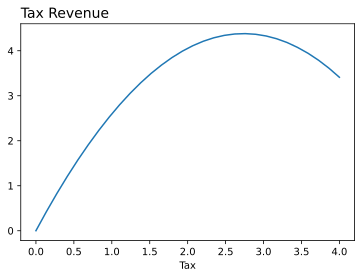

In [77]:
ts = jnp.linspace(0, 4., 30)
qs = jax.vmap(tax_revenue)(ts)

plt.plot(ts, qs)
plt.title('Tax Revenue', loc='left', size=14)
plt.xlabel('Tax')
plt.show()

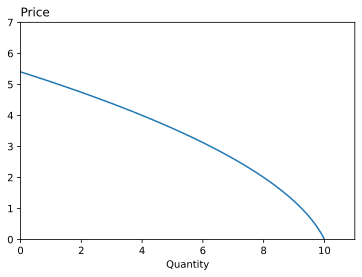

In [26]:
#@title Graph of Demand Function
ps = jnp.linspace(0, 10, 100)
qs = jax.vmap(demand)(ps)

plt.plot(qs, ps)
plt.title('Price', loc='left')
plt.xlabel('Quantity')
plt.xlim(0, 11)
plt.ylim(0, 7)
plt.show()

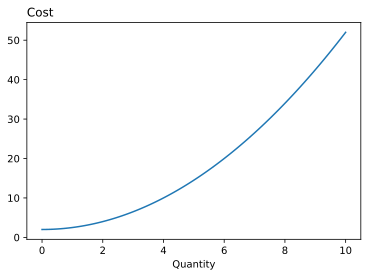

In [31]:
#@title Graph Cost Function { display-mode: "form" }
qs = jnp.linspace(0, 10, 100)
cs = jax.vmap(cost)(qs)

plt.plot(qs, cs)
plt.title('Cost', loc='left')
plt.xlabel('Quantity')
plt.show()

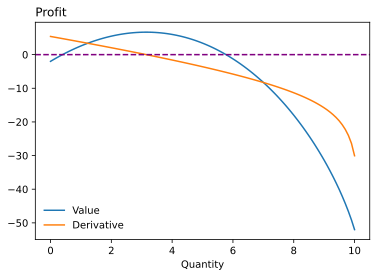

In [36]:
#@title Graph of Profit Function { display-mode: "form" }
tax = 0.0
qs = jnp.linspace(0, 10, 100)
vs = jax.vmap(partial(profit, demand, cost, tax))(qs)
vs_prime = jax.vmap(jax.grad(partial(profit, demand, cost, tax)))(qs)

plt.plot(qs, vs, label='Value')
plt.plot(qs, vs_prime, label='Derivative')
plt.axhline(0, linestyle='--', color='purple')
plt.title('Profit', loc='left')
plt.xlabel('Quantity')
plt.legend(frameon=False)
plt.show()

In [28]:
#@title Check Inverse Demand Function
ps = jnp.linspace(0, 5, 100)
ps_prime = jax.vmap(lambda p: inverse(demand)(demand(p)))(ps)
print(f"The maximium difference: {jnp.max(jnp.abs(ps-ps_prime)):.3f}")

The maximium difference: 0.001
